# Training Models

## Common Functions

In [1]:
train_models = {
    'BERT': False,
    'LSTM': False
}

take_quiz = False
update_dataset = False

SEED = 24

### Imports

In [2]:
import os
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import openai

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-11 16:33:19.098859: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 16:33:19.131248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 16:33:19.131354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 16:33:19.132493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has 

### Sample Generating Functions

In [3]:
def generate_samples(df, label, columnName, window=20, overlap=0):
    all_words = []
    samples = []

    # Flatten all words from all lines into one list
    for line in df[columnName]:
        if isinstance(line, str):  # skip NaNs
            all_words.extend(line.strip().split())

    i = 0
    # Create overlapping samples
    while i + window <= len(all_words):
        sample = all_words[i:i + window]
        samples.append(' '.join(sample))
        i += window - overlap

    return pd.DataFrame({
        'text': samples,
        'label': [label] * len(samples)
    })

def combine_split_save(shake_file, nonshake_file):
    shakespeare_df = pd.read_csv(shake_file)
    non_shakespeare_df = pd.read_csv(nonshake_file)

    shakespeare_df = generate_samples(shakespeare_df, 1, 'text')
    non_shakespeare_df = generate_samples(non_shakespeare_df, 0, 'sentence')

    min_len = min(len(shakespeare_df), len(non_shakespeare_df))
    shakespeare_df = shakespeare_df.sample(n=min_len, random_state=SEED).reset_index(drop=True)
    non_shakespeare_df = non_shakespeare_df.sample(n=min_len, random_state=SEED).reset_index(drop=True)

    combined_df = pd.concat([shakespeare_df, non_shakespeare_df], ignore_index=True)
    combined_df = combined_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=SEED)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

    train_df.to_csv('dataset1/train_data.csv', index=False)
    val_df.to_csv('dataset1/val_data.csv', index=False)
    test_df.to_csv('dataset1/test_data.csv', index=False)

In [4]:
if update_dataset:
    combine_split_save('shakespeare.csv', 'cleanNonShake.csv')

In [5]:
def load_data():
    train_df = pd.read_csv('dataset/train_data.csv')
    val_df = pd.read_csv('dataset/val_data.csv')

    return (train_df['text'].to_list(), val_df['text'].to_list(), 
            train_df['label'].to_list(), val_df['label'].to_list())

## Human Baseline

In [6]:
if take_quiz:
    # -----------------------------
    # 1. Load Data
    # -----------------------------

    test_df = pd.read_csv('dataset/test_data.csv')
    test_texts, test_labels = test_df['text'].to_list(), test_df['label'].to_list()
    questions = list(zip(test_texts, test_labels))

    # -----------------------------
    # 2. Start the Quiz
    # -----------------------------

    print("\nHuman Baseline Quiz: Is This Shakespeare?\n")
    print(f"Instructions: After reading the snippet (4 lines), enter 'y' for YES (Shakespeare) or 'n' for NO (Not Shakespeare).\n")
    print(f"Total questions this session: {len(questions)}\n")

    user_responses = []

    for idx, q in enumerate(questions):
        print("-" * 50)
        print(f"Question {idx + 1} / {len(questions)}:")
        print("-" * 50)
        print("\nSnippet:\n")
        text = q[0].split()
        for i in range(4):
            print(' '.join(text[5*i : 5*i+5]))
        print("\n")

        while True:
            user_input = input("Is this Shakespeare? (y/n): ").strip().lower()
            if user_input in ['y', 'n']:
                break
            else:
                print("Invalid input. Please enter 'y' for YES or 'n' for NO.")

        user_responses.append({
            'text': q[0],
            'true_label': q[1],
            'human_answer': 1 if user_input == 'y' else 0
        })

    # -----------------------------
    # 3. Save Results (APPEND)
    # -----------------------------

    results_df = pd.DataFrame(user_responses)
    filename = 'new_human_quiz_results.csv'

    if os.path.exists(filename):
        old_df = pd.read_csv(filename)
        full_df = pd.concat([old_df, results_df], ignore_index=True)
    else:
        full_df = results_df

    full_df.to_csv(filename, index=False)

    print(f"\nQuiz completed! Your answers have been saved to '{filename}'.\n")

## FFNN Class

In [7]:
unk = '<UNK>'
class FFNN(nn.Module):
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        self.flops = 0 #tracking its running time...ish
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation = nn.ReLU() # The rectified linear unit; one valid choice of activation function
        self.output_dim = 5
        self.W2 = nn.Linear(h, self.output_dim)

        self.softmax = nn.LogSoftmax() # The softmax function that converts vectors into probability distributions; computes log probabilities for computational benefits
        self.loss = nn.NLLLoss() # The cross-entropy/negative log likelihood loss taught in class

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector): # notes: gets called automatically when pytorch calls in the model
        self.flops += 2 * input_vector.shape[0] * self.W1.in_features * self.W1.out_features
        hidden_representation = self.W1(input_vector)  # shape of the layer [batch_size, h]
        # multiplied by the weight of the vector
        # puts high dimensional vector into lower dimensional space
        activated = self.activation(hidden_representation)  # rectified linear unit applies to elements
        # basically, introduces the non-linearity

        self.flops += 2 * activated.shape[0] * self.W2.in_features * self.W2.out_features
        output_logits = self.W2(activated)  # new weight is introduced
        #gets raw scores for the 5 classes/score (1-5)
        # combines hidden into classes

        predicted_vector = self.softmax(output_logits)  # softmax and log probability
        
        return predicted_vector

# # # # # # # # # ORDER OF IMPORTING DATA # # # # # # # # # #

def load_data_FFNN(train_file, val_file, test_file):
    import pandas as pd
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    test_df = pd.read_csv(test_file)

    # converting the dataframe (due to csv) to a tuple (due to json)
    train_data = list(zip(train_df["text"], train_df["label"]))
    valid_data = list(zip(val_df["text"], val_df["label"]))
    test_data = list(zip(test_df["text"], test_df["label"]))

    return train_data, valid_data, test_data

# Returns: 
# vocab = A set of strings corresponding to the vocabulary
def make_vocab(data):
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab 


# Returns:
# vocab = A set of strings corresponding to the vocabulary including <UNK>
# word2index = A dictionary mapping word/token to its index (a number in 0, ..., V - 1)
# index2word = A dictionary inverting the mapping of word2index
def make_indices(vocab):
    vocab_list = sorted(vocab)
    vocab_list.append(unk)
    word2index = {}
    index2word = {}
    for index, word in enumerate(vocab_list):
        word2index[word] = index
        index2word[index] = word
    vocab.add(unk)
    return vocab, word2index, index2word 


# Returns:
# vectorized_data = A list of pairs (vector representation of input, y)
def convert_to_vector_representation(data, word2index):
    vectorized_data = []
    for document, y in data:
        vector = torch.zeros(len(word2index))
        for word in document:
            index = word2index.get(word, word2index[unk])
            vector[index] += 1
        vectorized_data.append((vector, y))
    return vectorized_data


# load data
train_data, valid_data, test_data = load_data_FFNN('./dataset/train_data.csv', './dataset/val_data.csv', './dataset/test_data.csv')
vocab = make_vocab(train_data)
vocab, word2index, index2word = make_indices(vocab)

train_data = convert_to_vector_representation(train_data, word2index)
valid_data = convert_to_vector_representation(valid_data, word2index)
test_data = convert_to_vector_representation(test_data, word2index)

# HYPER PARAMETERS #########

def run_model(dims, eps):
    hidden_dim = dims
    epochs = eps


    model = FFNN(input_dim = len(vocab), h = hidden_dim)
    optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = None
        correct = 0
        total = 0
        start_time = time.time()
        random.shuffle(train_data) # Good practice to shuffle order of training data
        minibatch_size = 16 
        N = len(train_data) 
        for minibatch_index in tqdm(range(N // minibatch_size), disable=True):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_vector, gold_label = train_data[minibatch_index * minibatch_size + example_index]
                predicted_vector = model(input_vector)
                predicted_label = torch.argmax(predicted_vector)
                correct += int(predicted_label == gold_label)
                total += 1
                example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss
            loss = loss / minibatch_size
            loss.backward()
            optimizer.step()


        loss = None
        correct = 0
        total = 0
        start_time = time.time()
        minibatch_size = 16 
        N = len(valid_data) 
        for minibatch_index in tqdm(range(N // minibatch_size), disable=True):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_vector, gold_label = valid_data[minibatch_index * minibatch_size + example_index]
                predicted_vector = model(input_vector)
                predicted_label = torch.argmax(predicted_vector)
                correct += int(predicted_label == gold_label)
                total += 1
                example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss
            loss = loss / minibatch_size


    # Running portion

def ffnn_evaluate(model, dataloader):
    model.eval()
    actual_labels = []
    predictions = []
    probabilities = []

    with torch.no_grad():
        for input_vector, gold_label in dataloader:
            output = model(input_vector)
            probs = torch.exp(output)  # undo log-softmax to get probabilities

            predicted_label = torch.argmax(probs, dim=1)

            actual_labels.extend(gold_label.tolist())
            predictions.extend(predicted_label.tolist())

            # for binary classification
            if probs.shape[1] == 2:
                probabilities.extend(probs[:, 1].tolist())  # probability of positive class
            else:
                probabilities.extend(torch.max(probs, dim=1).values.tolist())  # max class prob

    return actual_labels, predictions, probabilities

In [8]:
class FFNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.stack(X)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## LSTM Classifier

### LSTM Tokenizer and Dataset Classes

In [9]:
class LSTMTokenizer:
    def __init__(self, texts, percentile=90):
        self.texts = [str(text).lower() for text in texts]
        self.tokenize = lambda text: text.split()
        
        # Build vocab
        all_tokens = []
        self.sentence_lengths = []
        for text in self.texts:
            tokens = self.tokenize(text)
            all_tokens.extend(tokens)
            self.sentence_lengths.append(len(tokens))

        self.vocab = {word: idx + 1 for idx, word in enumerate(set(all_tokens))}  # 0 = padding
        self.max_length = int(np.percentile(self.sentence_lengths, percentile))
    
    def encode(self, text):
        tokens = self.tokenize(str(text).lower())

        if not tokens:
            tokens = []

        ids = [self.vocab.get(token, 0) for token in tokens]  # 0 = unknown or pad
        ids += [0] * (self.max_length - len(ids))  # pad
        return ids[:self.max_length]

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.encode(self.texts[idx])

class LSTMTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer: LSTMTokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.encoded_labels = torch.LongTensor(self.label_encoder.fit_transform(labels))

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_ids = self.tokenizer.encode(self.texts[idx])
        return torch.LongTensor(input_ids), self.encoded_labels[idx]


### LSTM Model Class

In [10]:
# NEW
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim, 
            hidden_size=hidden_dim, 
            num_layers=1,
            batch_first=True, 
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))

        _, (hidden, _) = self.lstm(embedded)

        forward = hidden[-2, :, :]  # last layer, forward direction
        backward = hidden[-1, :, :]  # last layer, backward direction
        combined = torch.cat((forward, backward), dim=1)

        dropped = self.dropout(combined)
        output = self.fc(dropped)
        return output

# # OLD LSTM Model
# class LSTMClassifier(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
#         self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = self.embedding(x)
#         _, (hidden, _) = self.lstm(x)
#         out = self.fc(hidden[-1])
#         return out

### Train and Evaluate Functions

In [11]:
def train(model, train_loader, optimizer, criterion, device):
    # Training Loop
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(targets)
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)


### LSTM Model Instantiation and Parameters

In [12]:
num_epochs = 40
epoch_patience = 10
batch_size = 8
learning_rate = 5e-4 #0.001

train_texts, val_texts, train_labels, val_labels = load_data()

tokenizer = LSTMTokenizer(train_texts + val_texts) # Similar to original implemnentation but might be weird
train_dataset = LSTMTextDataset(train_texts, train_labels, tokenizer)
val_dataset = LSTMTextDataset(val_texts, val_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

model = LSTMClassifier(vocab_size=len(tokenizer.vocab), embed_dim=16, hidden_dim=16, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/root/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### Training the Model

In [13]:
if train_models['LSTM']:
    best_accuracy = 0
    counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, criterion, device='cpu')
        accuracy, report = evaluate(model, val_dataloader, device='cpu')
        print(f"Validation Accuracy: {accuracy:.4f}")
        accuracy, report = evaluate(model, train_dataloader, device='cpu')
        print(f"Training Accuracy: {accuracy:.4f}")
        print(report)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            counter = 0
            torch.save(model.state_dict(), "models/lstm_classifier.pth")
        else:
            counter += 1
            if counter > epoch_patience:
                print("Early stopping triggered.")
                break


## BERT Classifier

### BERT Dataset Class

In [14]:
class BERTTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

### BERT Model Class

In [15]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

### Train and Evaluate Functions

In [16]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "Shakespeare" if preds.item() == 1 else "Non-Shakespeare"

### BERT Model Instantiation and Parameters

In [17]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 10
epoch_patience = 3
learning_rate = 2e-5

train_texts, val_texts, train_labels, val_labels = load_data()

tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = BERTTextDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = BERTTextDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

device = "cpu"
model = BERTClassifier(bert_model_name, num_classes).to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/root/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in 

### Training the Model

In [18]:
if train_models['BERT']:
    best_accuracy = 0
    counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            counter = 0
            torch.save(model.state_dict(), "models/bert_classifier.pth")
        else:
            counter += 1
            if counter >= epoch_patience:
                print("Early stopping triggered.")
                break

# Evaluating Models

## Evaluation Model Functions

### Human

In [19]:
def human_evaluate(filename):
    df = pd.read_csv(filename)
    true_labels = df['true_label'].tolist()
    human_answers = df['human_answer'].tolist()
    return true_labels, human_answers

### LSTM

In [20]:
def lstm_evaluate(model, data_loader):
    model.eval()
    actual_labels = []
    predictions = []
    probabilities = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            actual_labels.extend(targets)
            predictions.extend(preds)
            probabilities.extend(probs)
    return actual_labels, predictions, probabilities

### BERT

In [21]:
def bert_evaluate(model, data_loader, device):
    model.eval()
    actual_labels = []
    predictions = []
    probabilities = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            actual_labels.extend(labels.cpu().tolist())
            predictions.extend(preds.cpu().tolist())
            probabilities.extend(probs.cpu().tolist())
    return actual_labels, predictions, probabilities

def bert_predict(text, model, tokenizer, device, max_length=128):
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        probs = torch.softmax(outputs, dim=1)[:, 1]
    return probs

## Running the Evaluations

### Setting Up Common Data

In [22]:
test_df = pd.read_csv('dataset/test_data.csv')
test_texts, test_labels = test_df['text'].to_list(), test_df['label'].to_list()
batch_size = 16
eval_data = {}

In [23]:
def plot_roc_curves(curve_data):
    for auc, fpr, tpr, model_name in curve_data:
        
        plt.plot(fpr, tpr, label=f"{model_name} AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [24]:
def plot_acc_f1(eval_data, models):
    fig, ax = plt.subplots()

    accuracies = []
    f1_scores = []
    for model in models:
        if model == 'HUMAN':
            ax.axhline(y=eval_data[model]['accuracy'], color='red', linestyle='--', label='Human Accuracy')
            ax.axhline(y=eval_data[model]['f1_score'], color='green', linestyle='--', label='Human F1 Score')
        else:
            accuracies.append(eval_data[model]['accuracy'])
            f1_scores.append(eval_data[model]['f1_score'])

    x = np.arange(len(models)-1)
    width = 0.35

    ax.bar(x - width/2, accuracies, width, label='Accuracy')
    ax.bar(x + width/2, f1_scores, width, label='F1 Score')

    ax.set_ylabel('Score')
    ax.set_title('Model Accuracy vs F1 Score')
    ax.set_xticks(x)
    ax.set_xticklabels([m for m in models if m != 'HUMAN'])
    ax.set_ylim(0, 1)
    ax.legend()
    plt.grid(axis='y')
    plt.show()


In [25]:
def plot_confusion_matrices(y_trues, y_preds, model_names, labels):
    num_models = len(model_names)
    rows = (num_models // 2) + (num_models % 2)
    cols = 2 if num_models > 1 else 1

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i in range(num_models):
        cm = confusion_matrix(y_trues[i], y_preds[i], labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                    xticklabels=labels, yticklabels=labels, cbar=False)
        axes[i].set_title(f'{model_names[i]}')
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')

    for j in range(num_models, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

### Human Evaluation

In [26]:
actual_labels, predictions = human_evaluate('new_human_quiz_results.csv')
eval_data['HUMAN'] = {
    'accuracy': accuracy_score(actual_labels, predictions),
    'f1_score': f1_score(actual_labels, predictions),
    'labels': actual_labels,
    'predictions': predictions
}
print(eval_data['HUMAN'])

{'accuracy': 0.6893939393939394, 'f1_score': 0.7320261437908496, 'labels': [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1], 'predictions': [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]}


### Naive Bayes Evaluation

In [27]:
with open("eval_data/naive.pkl", "rb") as f:
    naive_data = pickle.load(f)

eval_data['NAIVE'] = naive_data['NAIVE']
print(eval_data['NAIVE']['roc_score'])

(array([0.        , 0.07692308, 0.07692308, 0.15384615, 0.15384615,
       0.23076923, 0.23076923, 0.69230769, 0.69230769, 1.        ,
       1.        ]), array([0.  , 0.1 , 0.45, 0.45, 0.55, 0.55, 0.65, 0.65, 0.9 , 0.9 , 1.  ]), array([2.        , 1.        , 0.99999997, 0.99999981, 0.99999892,
       0.99999687, 0.99983426, 0.97655226, 0.94595385, 0.814008  ,
       0.61433033]))


F1 Score: 0.4
Accuracy: 0.36363636363636365


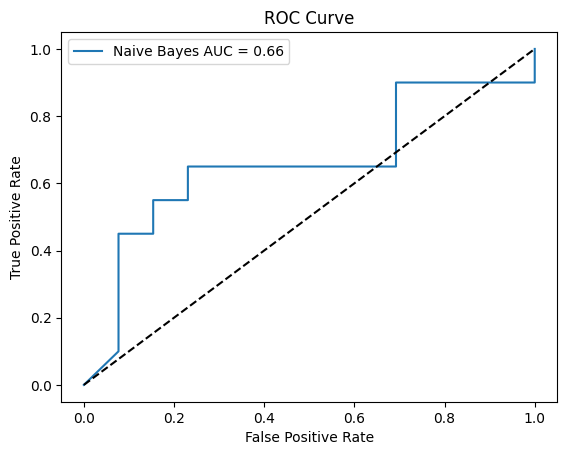

In [28]:
auc_score = eval_data['NAIVE']['auc_score']
fpr, tpr, _ = eval_data['NAIVE']['roc_score']
roc_data = [(auc_score, fpr, tpr, 'Naive Bayes')]
print('F1 Score:', eval_data['NAIVE']['f1_score'])
print('Accuracy:', eval_data['NAIVE']['accuracy'])
plot_roc_curves(roc_data)

### FFNN Evaluation

In [29]:
vectorized_test = []
for doc in test_texts:
    vector = torch.zeros(len(word2index))
    for word in doc:
        index = word2index.get(word, word2index[unk])
        vector[index] += 1
    vectorized_test.append(vector)

test_dataset = FFNNDataset(vectorized_test, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

model = FFNN(input_dim=65, h=8)
model.load_state_dict(torch.load("models/ffnn_model.pt"))
model.eval()

actual_labels, predictions, probabilities = ffnn_evaluate(model, test_dataloader)

eval_data['FFNN'] = {
    'accuracy': accuracy_score(actual_labels, predictions),
    'f1_score': f1_score(actual_labels, predictions),
    'auc_score': roc_auc_score(actual_labels, probabilities),
    'roc_score': roc_curve(actual_labels, probabilities),
    'labels': actual_labels,
    'predictions': predictions
}

/tmp/ipykernel_746/2606553930.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_vector = self.softmax(output_logits)  # softmax and log probability


F1 Score: 0.9500000000000001
Accuracy: 0.9393939393939394


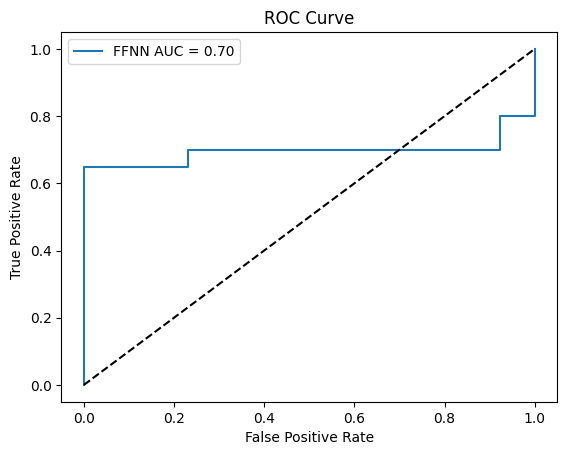

In [30]:
auc_score = eval_data['FFNN']['auc_score']
fpr_data, tpr_data = eval_data['FFNN']['roc_score'][:-1]
roc_data = [(auc_score, fpr_data, tpr_data, 'FFNN')]
print('F1 Score:', eval_data['FFNN']['f1_score'])
print('Accuracy:', eval_data['FFNN']['accuracy'])
plot_roc_curves(roc_data)

### LSTM Evaluation

In [31]:
tokenizer = LSTMTokenizer(train_texts + val_texts)
test_dataset = LSTMTextDataset(test_texts, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# len(tokenizer.vocab), embed_dim=32, hidden_dim=64, output_dim=2, dropout=0.5
model = LSTMClassifier(vocab_size=len(tokenizer.vocab), embed_dim=32, hidden_dim=64, output_dim=2) #, dropout=0.5)
model.load_state_dict(torch.load('models/best_lstm_classifier.pth'), strict=False)

actual_labels, predictions, probabilities = lstm_evaluate(model, test_dataloader)

eval_data['LSTM'] = {
    'accuracy': accuracy_score(actual_labels, predictions),
    'f1_score': f1_score(actual_labels, predictions), 
    'auc_score': roc_auc_score(actual_labels, probabilities),
    'roc_score': roc_curve(actual_labels, probabilities),
    'labels': actual_labels,
    'predictions': predictions
}


/root/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


F1 Score: 0.5555555555555556
Accuracy: 0.5151515151515151


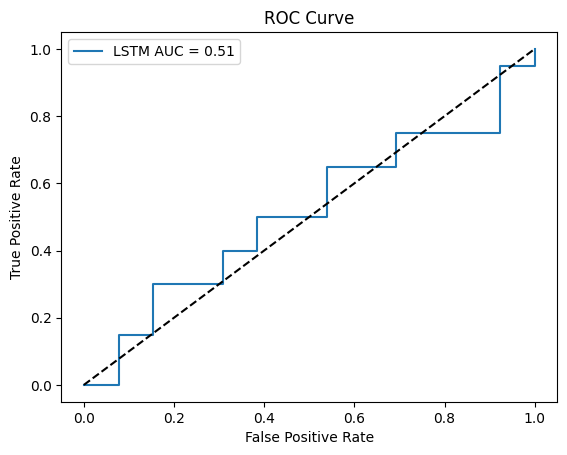

In [32]:
auc_score = eval_data['LSTM']['auc_score']
fpr_data, tpr_data = eval_data['LSTM']['roc_score'][:-1]
roc_data = [(auc_score, fpr_data, tpr_data, 'LSTM')]
print('F1 Score:', eval_data['LSTM']['f1_score'])
print('Accuracy:', eval_data['LSTM']['accuracy'])
plot_roc_curves(roc_data)


### BERT Evaluation

In [33]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
test_dataset = BERTTextDataset(test_texts, test_labels, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

device = "cpu"
model = BERTClassifier(bert_model_name, num_classes).to(device)
model.load_state_dict(torch.load('models/best_bert_classifier.pth'))

actual_labels, predictions, probabilities = bert_evaluate(model, test_dataloader, device)

eval_data['BERT'] = {
    'accuracy': accuracy_score(actual_labels, predictions),
    'f1_score': f1_score(actual_labels, predictions),
    'auc_score': roc_auc_score(actual_labels, probabilities),
    'roc_score': roc_curve(actual_labels, probabilities),
    'labels': actual_labels,
    'predictions': predictions
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1 Score: 1.0
Accuracy: 1.0


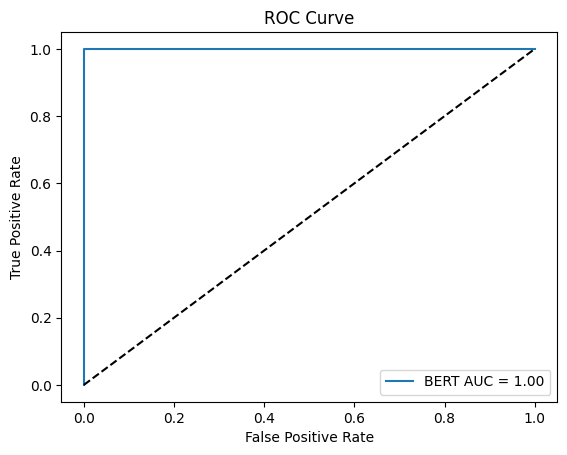

In [34]:
auc_score = eval_data['BERT']['auc_score']
fpr_data, tpr_data = eval_data['BERT']['roc_score'][:-1]
roc_data = [(auc_score, fpr_data, tpr_data, 'BERT')]
print('F1 Score:', eval_data['BERT']['f1_score'])
print('Accuracy:', eval_data['BERT']['accuracy'])
plot_roc_curves(roc_data)

### GPT Evaluation

In [35]:
from openai import OpenAI
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY") 
)

device = "cpu"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BERTClassifier(bert_model_name, num_classes).to(device)
model.load_state_dict(torch.load('models/best_bert_classifier.pth'))

train_df = pd.read_csv('dataset/train_data.csv')

shake_train = train_df[train_df['label'] == 1].iloc[:6]
nshake_train = train_df[train_df['label'] == 0].iloc[:6]

few_prompt = pd.concat([shake_train, nshake_train])
few_prompt = few_prompt.sample(frac=1).reset_index(drop=True)

few_shot_prompt = 'Classify the text from 1 ("Shakespearean") to 0 ("Not Shakespearean").'
for _, prompt in few_prompt.iterrows():
    few_shot_prompt += f'\n\nText: {prompt["text"]}\nConfidence: {bert_predict(prompt["text"], model, tokenizer, device).item():.3f}'

test_df = pd.read_csv('dataset/test_data.csv')
for _, data in test_df.iterrows():
    prompt = few_shot_prompt + f'\n\nText: {data["text"]}\nConfidence:'
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    confidence = float(response.choices[0].message.content.strip())
    if confidence > 0.5:
        label = 1
    else:
        label = 0
    actual_labels.append(data['label'])
    predictions.append(label)
    probabilities.append(confidence)

eval_data['GPT'] = {
    'accuracy': accuracy_score(actual_labels, predictions),
    'f1_score': f1_score(actual_labels, predictions),
    'auc_score': roc_auc_score(actual_labels, probabilities),
    'roc_score': roc_curve(actual_labels, probabilities),
    'labels': actual_labels,
    'predictions': predictions
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1 Score: 0.9629629629629629
Accuracy: 0.9545454545454546


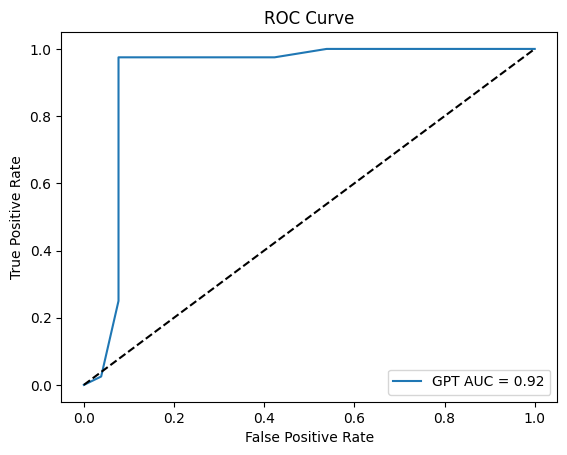

In [36]:
auc_score = eval_data['GPT']['auc_score']
fpr_data, tpr_data = eval_data['GPT']['roc_score'][:-1]
roc_data = [(auc_score, fpr_data, tpr_data, 'GPT')]
print('F1 Score:', eval_data['GPT']['f1_score'])
print('Accuracy:', eval_data['GPT']['accuracy'])
plot_roc_curves(roc_data)

## Combined Evaluation

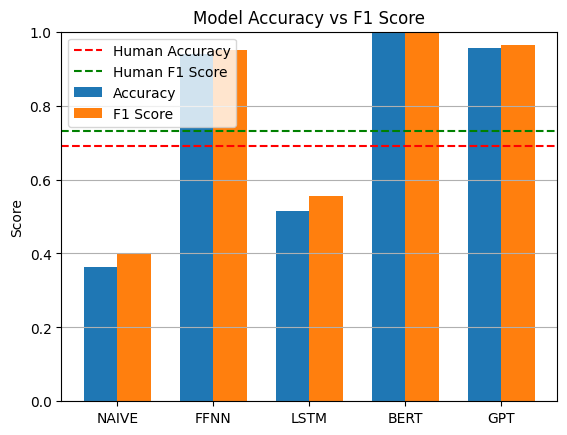

In [37]:
plot_acc_f1(eval_data, ['HUMAN', 'NAIVE', 'FFNN', 'LSTM', 'BERT', 'GPT'])

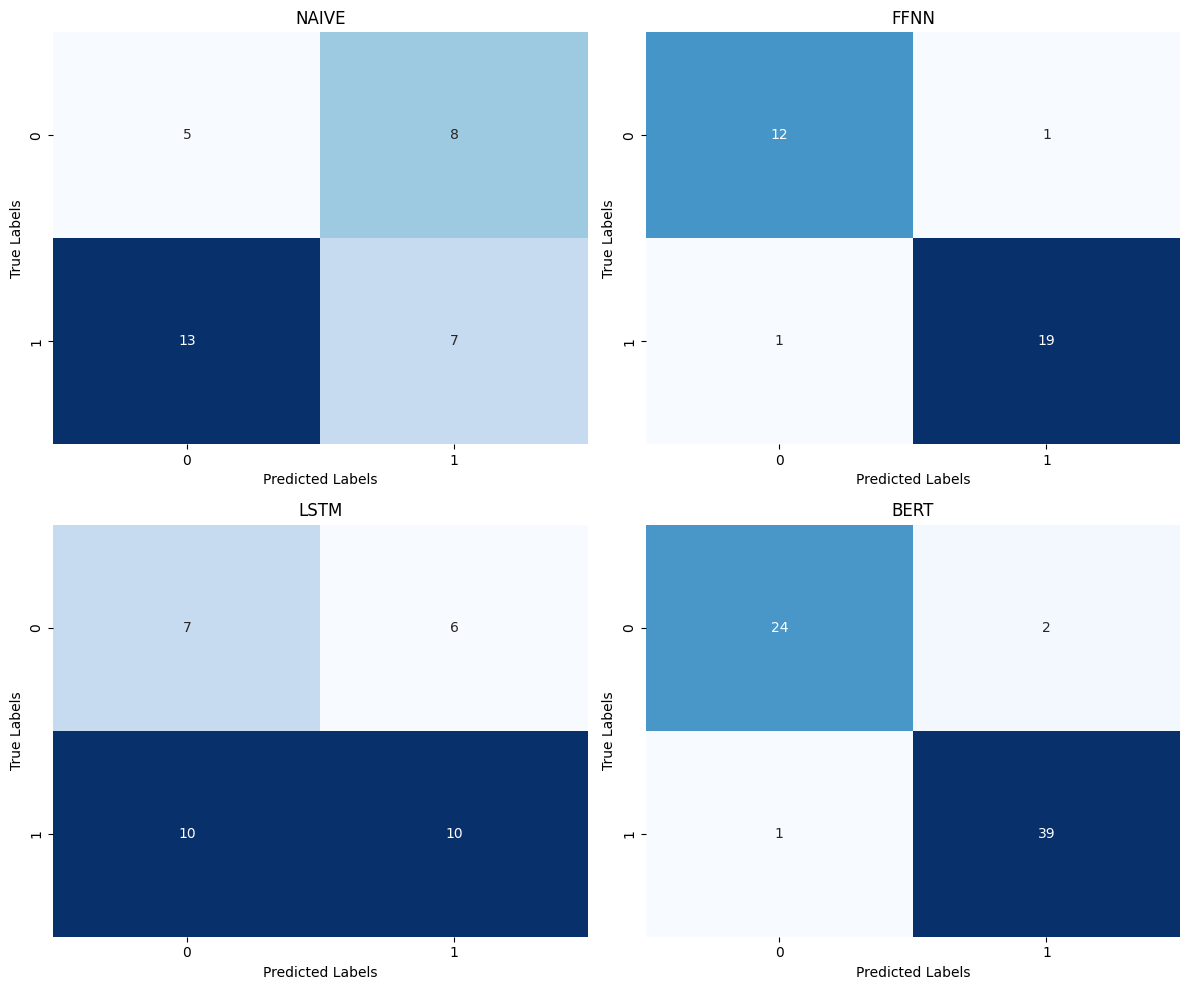

In [38]:
y_trues = []
y_preds = []
model_names = ['NAIVE', 'FFNN', 'LSTM', 'BERT']
for model_name in model_names:
    y_trues.append(eval_data[model_name]['labels'])
    y_preds.append(eval_data[model_name]['predictions'])
labels = [0, 1]

plot_confusion_matrices(y_trues, y_preds, model_names, labels)

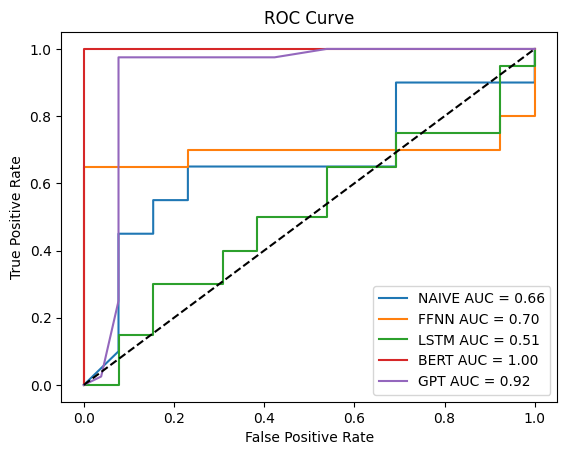

In [39]:
model_names = ['NAIVE', 'FFNN', 'LSTM', 'BERT', 'GPT']
roc_data = []
for model in model_names:
    auc_score = eval_data[model]['auc_score']
    fpr_data, tpr_data = eval_data[model]['roc_score'][:-1]
    roc_data.append((auc_score, fpr_data, tpr_data, model))
plot_roc_curves(roc_data)

In [40]:
model_names = ['HUMAN', 'NAIVE', 'FFNN', 'LSTM', 'BERT', 'GPT']
for model_name in model_names:
    print(model_name)
    print(classification_report(eval_data[model_name]['labels'], eval_data[model_name]['predictions']))
    print()

HUMAN
              precision    recall  f1-score   support

           0       0.59      0.67      0.63        52
           1       0.77      0.70      0.73        80

    accuracy                           0.69       132
   macro avg       0.68      0.69      0.68       132
weighted avg       0.70      0.69      0.69       132


NAIVE
              precision    recall  f1-score   support

           0       0.28      0.38      0.32        13
           1       0.47      0.35      0.40        20

    accuracy                           0.36        33
   macro avg       0.37      0.37      0.36        33
weighted avg       0.39      0.36      0.37        33


FFNN
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.95      0.95      0.95        20

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



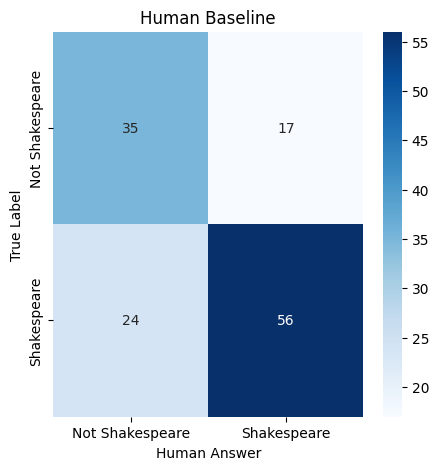

In [41]:
# Load the human quiz results
df = pd.read_csv('new_human_quiz_results.csv')

# Get true and predicted labels
y_true = df['true_label'].astype(int)
y_pred = df['human_answer'].astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Shakespeare", "Shakespeare"], yticklabels=["Not Shakespeare", "Shakespeare"])
plt.xlabel("Human Answer")
plt.ylabel("True Label")
plt.title("Human Baseline")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4cd1bb92-5c33-4c71-9500-71d9821d29e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>